# Multivariate LSTM 4 assets prediction
https://github.com/raiak82/LongShortMemorymodelNifty/blob/master/Nifty-Model.ipynb

https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679

https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## 1. Import Libraries

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
import math, re
import datetime as dt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
import seaborn as sns
%matplotlib inline

#LSTM RNN
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, utils
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error



Using TensorFlow backend.


In [2]:
# import asset data: open, close, volume
%store -r data_IVV
%store -r data_SHY
%store -r data_VNQ
%store -r data_GLD
%store -r vol_IVV
%store -r vol_SHY
%store -r vol_VNQ 
%store -r vol_GLD 

%store -r open_GLD
%store -r data_GSPC


In [3]:
#import market and econ data
%store -r data_gdp
%store -r data_savings
%store -r data_vix

# MULTIVARIATE LSTM - Single asset (in-sample) prediction
## Use Adj Close Price, Open Price, Volume, Savings Rate, and VIX to engineer the features

In [4]:
#market and econ data
#fill using previous values
#data_m = pd.concat([data_savings,data_vix],axis=1)
data_m = pd.concat([data_savings, data_vix],axis=1)
data_m = data_m.fillna(method='ffill')


In [5]:
GLD_all = pd.concat([data_GLD,open_GLD, vol_GLD, data_m],axis=1).dropna()
GLD_all.columns = ['Adj_Close','Open','Volume', 'Savings','VIX']

### Data info and visualize

In [6]:
GLD_all.head(3)

,Adj_Close,Open,Volume,Savings,VIX
Date,,,,,
2009-06-01,93.709999,93.709999,82888896.0,6.7,30.040001
2009-06-08,92.169998,92.169998,64057600.0,6.7,29.770000
2009-06-15,91.900002,91.900002,63132500.0,6.7,30.809999


In [7]:
GLD_all.tail(2)

,Adj_Close,Open,Volume,Savings,VIX
Date,,,,,
2019-05-13,120.650002,120.650002,39924600.0,8.0,20.549999
2019-05-20,121.300003,121.300003,20312500.0,8.0,16.309999


In [8]:
GLD_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 474 entries, 2009-06-01 to 2019-05-20
Data columns (total 5 columns):
Adj_Close    474 non-null float32
Open         474 non-null float32
Volume       474 non-null float32
Savings      474 non-null float64
VIX          474 non-null float32
dtypes: float32(4), float64(1)
memory usage: 14.8 KB


In [9]:
GLD_all.dtypes

Adj_Close    float32
Open         float32
Volume       float32
Savings      float64
VIX          float32
dtype: object

In [10]:
GLD_all.shape

(474, 5)

In [11]:
GLD_all.describe()

,Adj_Close,Open,Volume,Savings,VIX
count,474.000000,474.000000,474.0,474.000000,474.000000
mean,127.007332,127.007332,51331284.0,7.218565,17.550552
std,19.009182,19.009182,28932484.0,0.937042,6.121557
min,89.580002,89.580002,13757000.0,4.900000,9.340000
25%,115.414999,115.414999,33162250.0,6.700000,13.205000
50%,121.869999,121.869999,42775950.0,7.200000,15.960000
75%,133.107502,133.107502,61628625.0,7.600000,20.027501
max,183.240005,183.240005,235395008.0,12.000000,48.000000


In [12]:
GLD_all.columns

Index(['Adj_Close', 'Open', 'Volume', 'Savings', 'VIX'], dtype='object')

In [13]:
GLD_all.columns.get_loc("Adj_Close")

0

In [14]:
#sanity checks
GLD_all.isnull().sum()

Adj_Close    0
Open         0
Volume       0
Savings      0
VIX          0
dtype: int64

In [15]:
data_pct = GLD_all.pct_change()

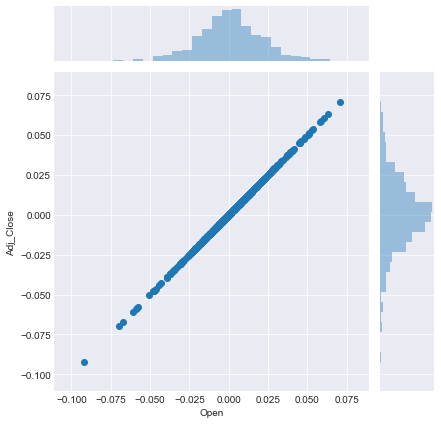

In [16]:
## Corr between open and close price
sns.jointplot(x='Open', y='Adj_Close', data=data_pct)  
plt.show()

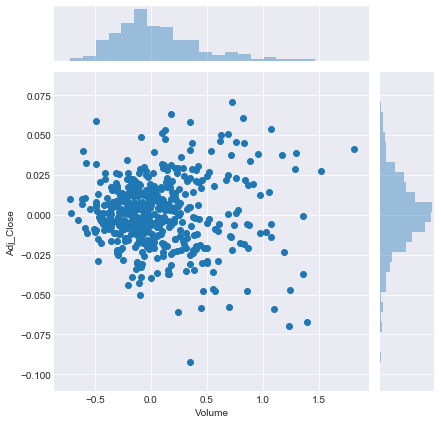

In [17]:
## Corr between volume and closing price
sns.jointplot(x='Volume', y='Adj_Close', data=data_pct)  
plt.show()

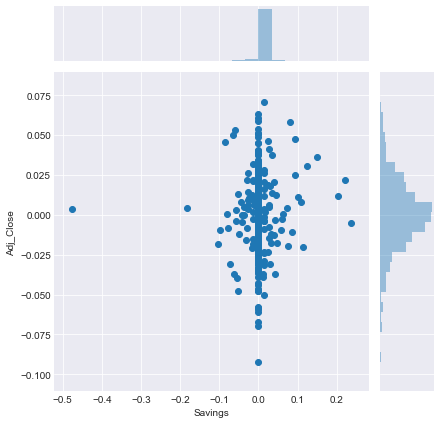

In [18]:
sns.jointplot(x='Savings', y='Adj_Close', data=data_pct)  
plt.show()

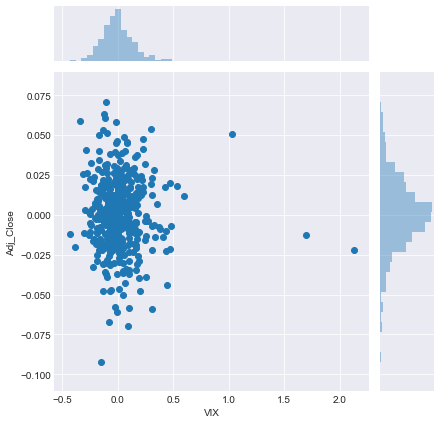

In [19]:
## Corr between volume and closing price
sns.jointplot(x='VIX', y='Adj_Close', data=data_pct)  
plt.show()

### Model helper functions
Predict closing price at t given closing price + other features at previous timesteps
* Convert time series to SUPERVISED LEARNING
* Using one lag observation as input (x)
* Using one observation as output (y)

In [20]:
# function to shift left and shift forward the time series dataframe where n_in paramter 
# used to shift left and n_out parameter used to shift right
def series_to_new_supervised(df, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(df) is list else df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    #names = df.columns.values
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(' %s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(' %s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [(' %s(t+%d)' % (df.columns[j], i))for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    else:
        agg = agg.fillna(0)
    return agg

In [21]:
#Columns to be removed from the transformed series. For example - after time series is shifted to N+1, you may want only-
#columns in shifted time series i.e you may want only adj_close rest other columns can be droped from N+1
def remove_columns_from_transformed_series(df2, main_column, negative, positive):
    columns_to_be_removed=[]
    for i in range(0,df2.shape[1]):
        string1=df2.columns[i]
        if re.search("\(t\-",string1): 
            if not (re.search(main_column,string1)):
                if (negative==1):
                    columns_to_be_removed.append(string1)
        if re.search("\(t\+",string1):
            if not (re.search(main_column,string1)):
                if (positive==1):
                    columns_to_be_removed.append(string1)
    df2.drop(columns_to_be_removed, axis=1, inplace=True)
    return df2

In [22]:
#shift series to obtain t+1 for Y column
shiftRightSeries=series_to_new_supervised(GLD_all,0,2)
print(shiftRightSeries.head(2))

             Adj_Close(t)    Open(t)   Volume(t)   Savings(t)     VIX(t)  \
Date                                                                       
2009-06-01      93.709999  93.709999  82888896.0          6.7  30.040001   
2009-06-08      92.169998  92.169998  64057600.0          6.7  29.770000   

             Adj_Close(t+1)   Open(t+1)   Volume(t+1)   Savings(t+1)  \
Date                                                                   
2009-06-01        92.169998   92.169998    64057600.0            6.7   
2009-06-08        91.900002   91.900002    63132500.0            6.7   

             VIX(t+1)  
Date                   
2009-06-01  29.770000  
2009-06-08  30.809999  


-------------------------- Additional stuff --------------------------

In [23]:
# Only keep adj close as it is the only variable for prediction
shiftRightSeries=remove_columns_from_transformed_series(shiftRightSeries,"Adj_Close",1,1)
print(shiftRightSeries.head(2))

             Adj_Close(t)    Open(t)   Volume(t)   Savings(t)     VIX(t)  \
Date                                                                       
2009-06-01      93.709999  93.709999  82888896.0          6.7  30.040001   
2009-06-08      92.169998  92.169998  64057600.0          6.7  29.770000   

             Adj_Close(t+1)  
Date                         
2009-06-01        92.169998  
2009-06-08        91.900002  


In [24]:
#Seperate Independant and dependant variables in X and Y respectively
X=shiftRightSeries.iloc[:,:-1]
y=shiftRightSeries.iloc[:,-1]
print(X.head(2))
print(y.head(2))

             Adj_Close(t)    Open(t)   Volume(t)   Savings(t)     VIX(t)
Date                                                                    
2009-06-01      93.709999  93.709999  82888896.0          6.7  30.040001
2009-06-08      92.169998  92.169998  64057600.0          6.7  29.770000
Date
2009-06-01    92.169998
2009-06-08    91.900002
Name:  Adj_Close(t+1), dtype: float32


In [25]:
#One of the common issue related to machine learning problem- Y variable (if int or float) throws error when you fit the logistic regression model
#In order to solve it, you may need to convert the Y variable to label encoded format

lab_enc = preprocessing.LabelEncoder()
y_scores_encoded = lab_enc.fit_transform(y)
print(utils.multiclass.type_of_target(y_scores_encoded))

multiclass


In [26]:
#Selecting logistic Regression to select top 15 best features
model = LogisticRegression()
rfe = RFE(model, 15)
fit = rfe.fit(X, y_scores_encoded)
print("Num Features: %d" % (fit.n_features_,))
print("Selected Features: %s" % (fit.support_,))
print("Feature Ranking: %s" % (fit.ranking_,))

Num Features: 5
Selected Features: [ True  True  True  True  True]
Feature Ranking: [1 1 1 1 1]


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [27]:
#Identifying the importance of feature based on ExtraTreeClassifications
model = ExtraTreesClassifier()
model.fit(X,y_scores_encoded)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.21408838 0.21145821 0.21256672 0.15386107 0.20802562]


//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


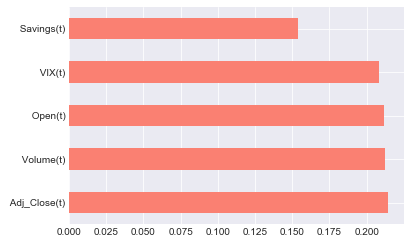

In [28]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(21).plot(kind='barh', color='salmon')
plt.show()

--------------------------^^ Additional stuff ^^--------------------------

In [29]:
# normalize features
mm = MinMaxScaler(feature_range=(0, 1))
scaled = mm.fit_transform(shiftRightSeries)

X_new=scaled[:,:-1]
y_new=scaled[:,-1]
lab_enc = preprocessing.LabelEncoder()
y_scores_encoded_new = lab_enc.fit_transform(y_new)
print(y_scores_encoded_new)
print(utils.multiclass.type_of_target(y_new))
print(utils.multiclass.type_of_target(y_scores_encoded))

[  4   2   5   1   0   3   8   7  10   6   9  11  13  15  12  14  20  24
  25  19  40  56  81 107  92  54  50  46  39  66  61  35  31  38  55  60
  43  45  47  58  91  65  86 113 155 191 110 168 187 235 233 161 130 124
 115 149 166 186 203 220 260 293 315 323 333 319 327 343 334 324 330 344
 341 336 339 347 332 328 320 323 325 341 350 345 346 349 348 354 357 361
 366 358 359 362 364 363 365 360 356 381 385 392 410 434 444 443 445 442
 399 391 394 414 397 432 436 441 427 414 433 423 382 386 395 430 428 425
 426 421 422 405 408 412 393 403 398 406 396 372 378 369 379 390 368 380
 374 376 373 389 383 388 387 411 416 437 439 438 440 435 424 419 429 418
 431 420 417 415 400 402 401 404 413 407 409 384 367 370 375 383 377 371
 355 342 352 353 351 322 335 331 337 267 170 154 252 269 314 286 296 326
 340 338 308 309 316 289 231 295 321 298 254 255 185 197 162 176 121 140
 173 189 201 188 225 300 306 318 329 313 261 277 297 263 272 268 251 258
 259 193 238 288 292 301 314 283 279 256 284 273 24

           Specs      Score
4         VIX(t)  53.185088
0   Adj_Close(t)  48.689289
1        Open(t)  48.689289
2      Volume(t)  45.699404


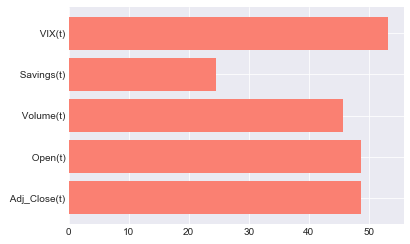

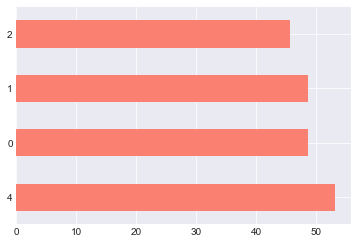

           Specs      Score
0   Adj_Close(t)  48.689289
1        Open(t)  48.689289
2      Volume(t)  45.699404
3     Savings(t)  24.583340
4         VIX(t)  53.185088


In [30]:
#plot graph of feature importances for better visualization
#feat_importances = pd.Series(featureScores['Score'],index=featureScores['Specs'])
#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=chi2, k=4)
fit = bestfeatures.fit(X_new,y_scores_encoded_new)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(4,'Score'))  #print 10 best features
plt.barh(featureScores['Specs'],featureScores['Score'], color = 'salmon')
plt.show()
featureScores['Score'].nlargest(4).plot(kind='barh', color = 'salmon')
plt.show()
print(featureScores)

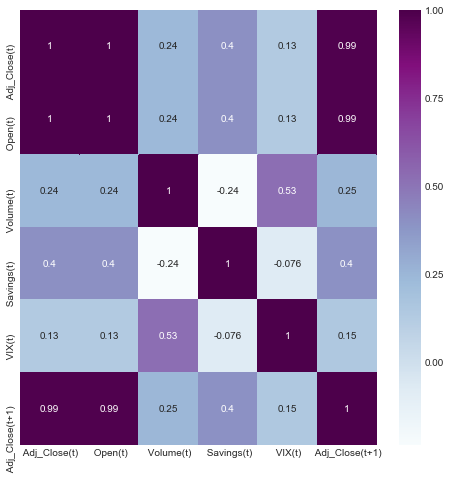

In [31]:
#get correlations of each features in dataset
corrmat = shiftRightSeries.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,8))
#plot heat map
g=sns.heatmap(shiftRightSeries[top_corr_features].corr(),annot=True,cmap='BuPu')

---------------- The end of feature filtering ----------------- 

In [32]:
# reframing the time series to have (t-5) data in order to create LSTM time series model
reframe_series_5=series_to_new_supervised(GLD_all,5,1)
reframe_series_5=remove_columns_from_transformed_series(reframe_series_5,"Adj_Close",0,1)
print(reframe_series_5.tail(2))

             Adj_Close(t-5)   Open(t-5)   Volume(t-5)   Savings(t-5)  \
Date                                                                   
2019-05-13       121.830002  121.830002    32231300.0            8.1   
2019-05-20       120.370003  120.370003    23134500.0            8.1   

             VIX(t-5)   Adj_Close(t-4)   Open(t-4)   Volume(t-4)  \
Date                                                               
2019-05-13      13.18       120.370003  120.370003    23134500.0   
2019-05-20      12.32       121.370003  121.370003    22858300.0   

             Savings(t-4)   VIX(t-4)  ...   Adj_Close(t-1)   Open(t-1)  \
Date                                  ...                                
2019-05-13            8.1      12.32  ...       121.430000  121.430000   
2019-05-20            8.1      12.42  ...       120.650002  120.650002   

             Volume(t-1)   Savings(t-1)   VIX(t-1)   Adj_Close(t)     Open(t)  \
Date                                                        

In [33]:
t_features=len(GLD_all.columns)
timesteps=5
sequence=t_features*timesteps

In [34]:
# Drop other columns from output other than Adj_Close(t)
columns_to_remove=[]
for i in range(sequence+1, len(reframe_series_5.columns)):
    #print(reframe_series_5.columns[i])
    columns_to_remove.append(reframe_series_5.columns[i])
    
reframe_series_5.drop(columns_to_remove, axis=1, inplace=True)
print(reframe_series_5.tail(2))

             Adj_Close(t-5)   Open(t-5)   Volume(t-5)   Savings(t-5)  \
Date                                                                   
2019-05-13       121.830002  121.830002    32231300.0            8.1   
2019-05-20       120.370003  120.370003    23134500.0            8.1   

             VIX(t-5)   Adj_Close(t-4)   Open(t-4)   Volume(t-4)  \
Date                                                               
2019-05-13      13.18       120.370003  120.370003    23134500.0   
2019-05-20      12.32       121.370003  121.370003    22858300.0   

             Savings(t-4)   VIX(t-4)  ...   Open(t-2)   Volume(t-2)  \
Date                                  ...                             
2019-05-13            8.1      12.32  ...  120.650002    36733700.0   
2019-05-20            8.1      12.42  ...  121.430000    21270600.0   

             Savings(t-2)   VIX(t-2)   Adj_Close(t-1)   Open(t-1)  \
Date                                                                
2019-05-13     

In [35]:
# ensure all data is float
values=reframe_series_5.values
values = values.astype('float32')

# normalize features
scaled_values = mm.fit_transform(values)
 
# split into train and test sets
TRAIN_SPLIT = 313
train = scaled_values[:TRAIN_SPLIT,:]
test = scaled_values[TRAIN_SPLIT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1 ], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print("Time Steps =", timesteps)
print("Number of Features considered =", t_features)

(313, 25) (313,) (156, 25) (156,)
Time Steps = 5
Number of Features considered = 5


In [36]:
# reshape input to be 3D [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], timesteps, t_features))
test_X = test_X.reshape((test_X.shape[0], timesteps, t_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(313, 5, 5) (313,) (156, 5, 5) (156,)


In [37]:
NUM_NEURONS_FirstLayer = 64
NUM_NEURONS_SecondLayer = 32
EPOCHS = 200

In [38]:
train_X.shape[1], train_X.shape[2]

(5, 5)

In [39]:
# design LSTM network

model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(NUM_NEURONS_SecondLayer, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))
model.add(LSTM(NUM_NEURONS_SecondLayer, input_shape=(NUM_NEURONS_FirstLayer,train_X.shape[2]),return_sequences=False))

#model.add(LSTM(NUM_NEURONS_SecondLayer, train_X.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics=['mse'])

 # fit network
history = model.fit(train_X, train_y, epochs=EPOCHS, batch_size=25, validation_data=(test_X, test_y), shuffle=True, verbose=2)

W0904 16:03:42.080402 4572923328 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 16:03:42.114109 4572923328 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 16:03:42.117074 4572923328 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 16:03:42.509782 4572923328 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0904 16:03:42.514455 4572923328 depre

Train on 313 samples, validate on 156 samples
Epoch 1/200
 - 4s - loss: 0.1428 - mean_squared_error: 0.1428 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/200
 - 0s - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 3/200
 - 0s - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/200
 - 0s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 8/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 9/200
 - 0s - loss: 0.0044 - mean_sq

Epoch 72/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 73/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 74/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 75/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 76/200
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 77/200
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 78/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 79/200
 - 0s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 80/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.001

Epoch 142/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 9.2771e-04 - val_mean_squared_error: 9.2771e-04
Epoch 143/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 144/200
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 8.9874e-04 - val_mean_squared_error: 8.9874e-04
Epoch 145/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 8.8843e-04 - val_mean_squared_error: 8.8843e-04
Epoch 146/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 9.1181e-04 - val_mean_squared_error: 9.1181e-04
Epoch 147/200
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 148/200
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 8.8630e-04 - val_mean_squared_error: 8.8630e-04
Epoch 149/200
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 9.4475e-04 - val_mean_squared_error: 9.4475e-04
Epoch 150/200
 - 0s - lo

In [40]:
# make a prediction
inv_ypred = model.predict(test_X)
# inverse reshape of test_X array
test_X = test_X.reshape((test_X.shape[0], sequence))
print (test_X.shape)

(156, 25)


In [41]:
# invert scaling for forecast
inv_ypred = np.concatenate((test_X[:, :], inv_ypred), axis=1)
print(inv_ypred.shape)
inv_ypred = mm.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,-1]

(156, 26)


In [42]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X[:, :], test_y), axis=1)
inv_y = mm.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

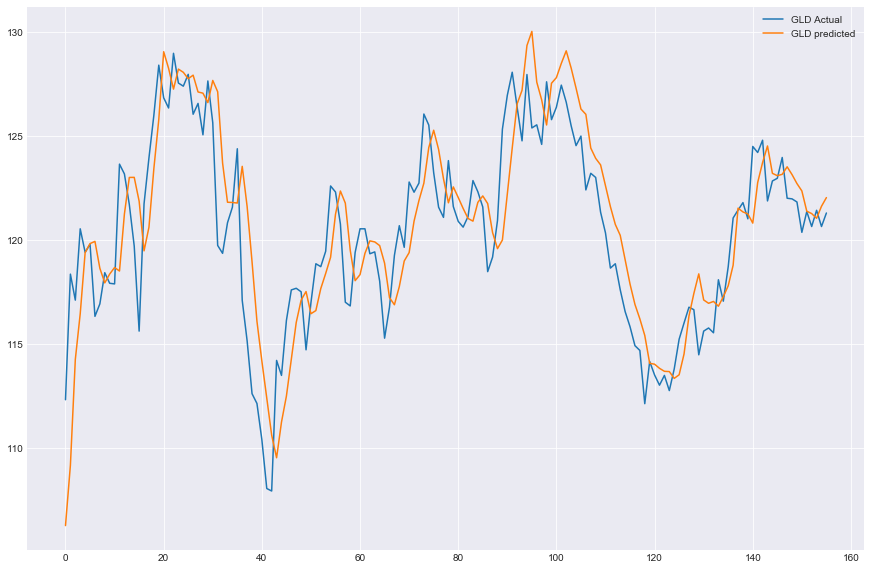

In [43]:
# Plot actual v. predicted
plt.figure(figsize=(15, 10))
plt.plot(inv_y, label='GLD Actual')
plt.plot(inv_ypred, label='GLD predicted')
plt.legend()
plt.show()

In [44]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = mm.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = mm.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

NameError: name 'model1' is not defined

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse, rmse, r2, Y_test, Y_hat
  